# VoterKarma model testing
_This notebook outlines the steps for testing the model used for creating VoterKarma scores_

In [2]:
import pdb
import datetime
import json
import psycopg2 as pg
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
from operator import itemgetter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search as gs
from sklearn import cross_validation as cv
from sklearn.metrics import roc_curve

In [2]:
#Read in db access information
vk_access = {}
with open('./db_vars', 'r') as f:
    for l in f.readlines():
        vk_access[l.split('=')[0]] = l.split('=')[1].strip('\n')

### Utilities

In [3]:
# Utilities
def date_to_years(start, end=datetime.date.today()):
    return (end - start.date()).days / 365

def convert_to_date(col):
    return pd.to_datetime(col, errors='ignore', format="%Y-%m-%d")

### Global vars

In [4]:
#Limit % of observations to retrieve
LIMIT = .25
#Columns in database
HEADERS = (
'id', 'dob', 'gender', 'status', 'enrollment', 'district', 'regdate', 
'idrequired', 'idmet',
'e2001_09_primary',
'e2001_11_general',
'e2005_09_primary',
'e2005_11_general',
'e2006_11_general',
'e2008_02_primary',
'e2008_11_general',
'e2009_09_primary',
'e2009_11_general',
'e2010_09_primary',
'e2010_11_general',
'e2012_06_primary',
'e2012_09_primary',
'e2012_11_general',
'e2013_09_primary',
'e2013_11_general',
'e2014_06_primary',
'e2014_11_general'
)
#Recent elections (column names)
RECENT = {'local_primary':'e2013_09_primary', 
               'local_general':'e2013_11_general', 
               'national_midterm':'e2014_11_general',
               'national_presidential': 'e2012_11_general'}

### Data pulling
Requires connection to vk RDS.  Use `LIMIT` global to limit number of observations.  Total dataset is >3M rows

In [5]:
def pulldata(limit=None):
    conn = pg.connect(database = vk_access['VK_DB'], user = vk_access['VK_U'], password = vk_access['VK_PW'],
        host = vk_access['VK_HOST'], port = vk_access['VK_PORT'])

    cur = conn.cursor()

    sel = """
    SELECT {}
    FROM {}
    """.format(', '.join(HEADERS), 'rawvoters')

    if limit is not None:
        sel += " TABLESAMPLE BERNOULLI({})".format(limit)

    cur.execute(sel)
    df = pd.DataFrame.from_records(cur.fetchall(), columns=HEADERS)
    return(df)

In [6]:
raw_df = pulldata(limit = LIMIT)

### Data processing

In [7]:
def process(data):
    # Set index to 'id' and drop id
    df = data.set_index(['id']).copy(deep=True)
    # Convert Date fields to years duration
    df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(convert_to_date)
    df[df.select_dtypes(['datetime64[ns]']).columns] = \
            df.select_dtypes(['datetime64[ns]']).applymap(lambda x:
                    date_to_years(x))
    #DOB range 18-167, probably fair to drop anyone >=100
    df = df[df.dob<100]
    # Create categories and pivot them
    df[df.select_dtypes(['object']).columns] = \
            df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

    # Pivot categorical variables
    cat_cols = df.select_dtypes(['category']).columns
    for col in cat_cols:
        dummy = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummy], axis=1)

    df.drop(cat_cols, axis=1, inplace=True)
    return(df)

In [8]:
df = process(raw_df)

### Exploratory analysis

Average ages e2013_11_general: voters 57.8336646786, non-voters 49.7095330449
Average ages e2013_09_primary: voters 59.5296367113, non-voters 49.9868825007
Average ages e2012_11_general: voters 52.8100524206, non-voters 50.1531495271
Average ages e2014_11_general: voters 57.7946685879, non-voters 49.8615181712


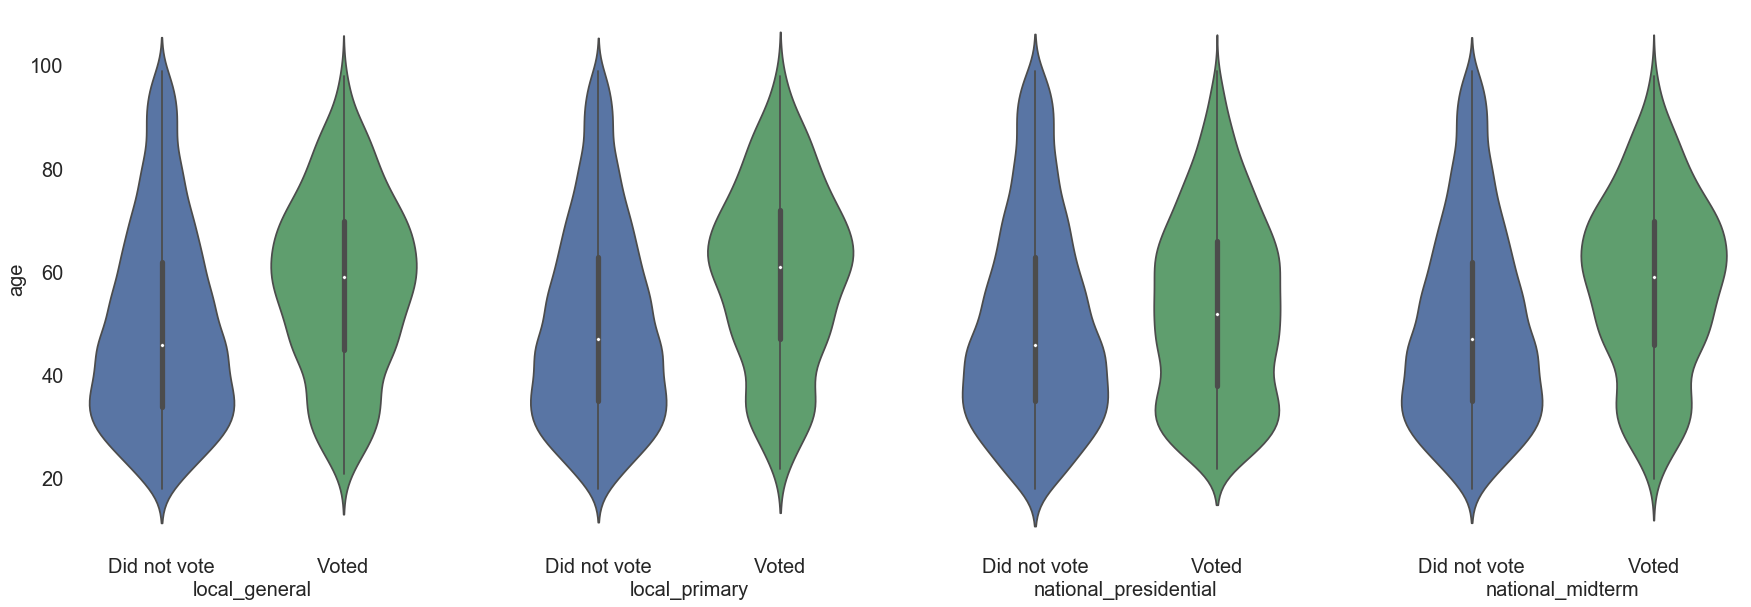

In [9]:
fig,axs = plt.subplots(1,4, figsize=(30, 10), sharey=True)
i = 0
for v in RECENT.values():
    avg = df.groupby(v)['dob'].mean()
    print "Average ages {}: voters {}, non-voters {}".format(v, avg[True], avg[False])
    sns.violinplot(x=v ,y='dob', data=df, ax=axs[i])
    axs[i].set_facecolor('white')
    axs[i].set_xlabel([k for k in RECENT if RECENT[k]==axs[i].get_xlabel()][0], size=20)
    axs[i].set_xticklabels(['Did not vote', 'Voted'])
    axs[i].tick_params(labelsize=20)
    if i!=0:
        axs[i].set_ylabel('')
    else:
        axs[i].set_ylabel('age', size=20)
    i+=1
plt.show()

### Model testing

In [10]:
#Model parameters
#Which models
models = ['xg','RandomForest','LogisticRegression'] 
params = dict()

#general hyperparameters
njobs = -1 #number of jobs to run in parallel
pmetric = 'roc_auc' #Useful for unbalanced classes

#tuning parameters for randomizedsearchcv
params['iter'] = 5 #number of iterations
params['folds'] = 5 #folds for cv (default)

#LogisticRegression model parameters
params['LogisticRegression'] = dict()
params['LogisticRegression']['penalty'] = ['l1','l2']
params['LogisticRegression']['C'] = ss.beta(a=2,b=25) #beta distribution for selecting reg strength

#RandomForest model parameters
params['RandomForest'] = dict()
params['RandomForest']['n_estimators'] = [2**8] #number of trees in the forest
params['RandomForest']['max_features'] = ss.beta(a=2,b=15) #number of features at split
params['RandomForest']['max_leaf_nodes'] = ss.nbinom(n=2,p=0.001,loc=100) #max number of leaves to create

#xgBoost model parameters
params['xg'] = dict()
params['xg']['max_depth'] = range(3, 7)
params['xg']['min_child_weight'] = range(1, 5)
params['xg']['learning_rate'] = ss.beta(a=2,b=15)

In [11]:
def gridsearch(data,target,features,model,mparams):
    #Get xy
    x,y = data[features], data[target]
    if model == 'LogisticRegression':
        lr = LogisticRegression()
        grid = gs.RandomizedSearchCV(lr, 
                    dict(
                        penalty=mparams['penalty'],
                        C=mparams['C']
                        ), 
                    scoring=pmetric, n_jobs=njobs, 
                    cv = cv.KFold(len(data),params['folds']), 
                    refit=False, n_iter=params['iter'])
    elif model == 'xg':
        xgb_c = xgb.XGBClassifier(objective = 'binary:logistic')
        grid = gs.RandomizedSearchCV(xgb_c, 
                    dict(
                        max_depth = mparams['max_depth'],
                        min_child_weight = mparams['min_child_weight'],
                        learning_rate = mparams['learning_rate']
                        ), 
                    scoring=pmetric, 
                    cv = cv.KFold(len(data),params['folds']), 
                    refit=False, n_iter=params['iter'])
    else:
        rf = RandomForestClassifier()        
        grid = gs.RandomizedSearchCV(rf, 
                    dict(
                        n_estimators=mparams['n_estimators'],
                        max_features=mparams['max_features'],
                        max_leaf_nodes=mparams['max_leaf_nodes']
                        ), 
                    scoring=pmetric, n_jobs=njobs, 
                    cv=cv.KFold(len(data), params['folds']), 
                                     refit=False, n_iter=params['iter'])
    grid.fit(X=x,y=y)    
    bp = grid.best_params_
    bs = grid.best_score_
    return(bs, bp)

In [12]:
def aucplt(train, test, target, features, models, params, save=False):
    plt.figure(facecolor='white')
    plt.plot([0, 1], [0, 1], 'k--')
    
    for model in models:
        best_params = params[model]
        if model == 'RandomForest':
            m = RandomForestClassifier(**best_params)
            fit_m = m.fit(train[features],train[target])
        elif model == 'xg':
            m = xgb.XGBClassifier(objective = 'binary:logistic', **best_params)
            fit_m = m.fit(train[features],train[target])
        else:
            m = LogisticRegression(**best_params)
            fit_m = m.fit(train[features],train[target])
        m_pred = m.predict_proba(test[features])[:, 1]
        fpr_m, tpr_m, _ = roc_curve(test[target], m_pred)
        plt.plot(fpr_m, tpr_m, label=model)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(target)
    plt.legend(loc='best')
                
    if save:
        plt.savefig('roc.png', facecolor='white')
    plt.show()

In [13]:
#Get best hyperparameters
m_params = {}
#Get performance
m_perf = {}
for k,v in RECENT.items():
    m_params[k] = {}
    m_perf[k] = {}
    for m in models:
        m_perf[k][m], m_params[k][m]  = gridsearch(df, v, 
                                  [f for f in df.columns if f!=v],
                                 m, params[m])

In [14]:
#Retrieve out-of-sample data
test = pulldata(limit=10)
test = process(test)

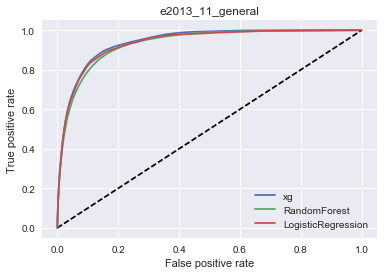

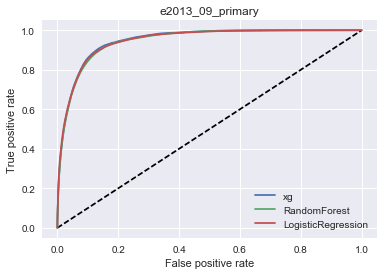

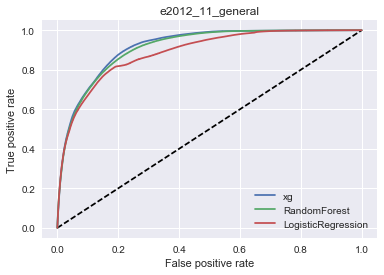

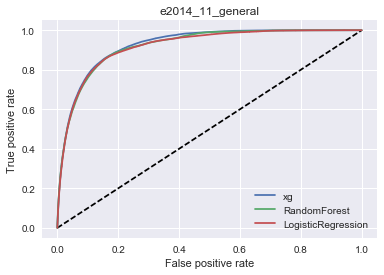

In [15]:
#Run AUC plots with best parameters
fit_m = {}
for k,v in RECENT.items():
     aucplt(df, test, v, 
                      [f for f in df.columns if f!=v],
                     models, m_params[k])

In [16]:
#Output best parameters to json
bp = []
with open('best_params.json', 'w') as f:
    for k in RECENT:
        bp.append({'target':k, 'params':[m_params[k][m] for m in m_perf[k] if m == max(m_perf[k])]})
    json.dump(bp, f)